![I_made_this_in_facebook_messenger_I_kid_you_not](https://raw.githubusercontent.com/crowegian/memes/master/ImATerribleTA.jpg)


# Lab 6: Convolutional Neural Networks
Lab 6 will follow a lot of the same steps that lab 5 did, but instead of using a fully connected neural network (FCNN) you'll be using a convolutional neural network (CNN). CNNs work well when the inputs have spatial patterns that can be learned. Images fall into this category as neighboring pixels are often correlated. CNNs follow a basic form of INPUT -> CONV_LAYER(CONV -> ACTIVATION_FUNCTION -> POOL)*d -> FCNN where CONV_LAYER can have d layers and the FCNN at the end can be as deep or shallow as you want. 

For the rest of this explanation I'm about to drop some knowledge straight out of [Intuitively Understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1). All images are from this site, unless otherwise noted.

## Convolutions
The main workhorse of the CNN is the kernel. The kernel is a learnable matrix, which is used to pick out (indicated by a strong activation) visual features. Below is an example of a 3x3 kernel (dark blue) convolving over the width and height an image to produce an output (grey).
![2dConvSingleKernel](img/2dConvKernel.gif)

The kernel is essentially a weighted sum over the inputs. A more concrete example is below.
![2dConvWithNums](img/2dConvWithNums.gif)


## Striding
Sometimes when we're performing convolutions we want the output to be smaller than the input. This can be achieved by increasing the size of our kernels (not the best way to achieve arbitrary shrinkage) or making the kernel skip over some pixels when convolving across an image also known as striding.

![2dConvWithStriding](img/2dConvWithStriding.gif)

The image above has a stride of two, which reduces the output shape by a factor of 2. A stride of 3 would reduce the output shape by a factor of 3, and so on.

Another way to reduce size is with a pooling operation

## Pooling

Pooling is a technique to introduce invariance to small translations as well as reduce the output size. There are many forms of pooling using averaging, L2-norms, but max pooling is the most common. An example of max pooling with a stride of 2 over the output of each convolution of a 2x2 kernel is below.

![maxpool](img/maxpool.jpeg)
[source](http://cs231n.github.io/convolutional-networks/)


## Padding
Now you know two ways of reducing the size of each layer using kernels, and striding. But if you keep reducing size eventually you'll have nothing to work with and you can't make arbitrarily deep models. Padding is a technique where you concatenate pixels to the edges of an image, so that the output after a convlutional layer is that same size as the input. This can also be done during a pooling step, but that's not super common.
![2dConvWithPadding](img/2dConvWithPadding.gif)

## Output shapes
Kernel shape, padding, and stride all affect the output shape after a convolution, or pooling layer. Here are some formulas to help you figure out the shape of the output for a square input. Let $O$ be the output shape, $W$ be the input shape, $K$ be the kernel size, $P$ be the amount of padding, and $S$ the stride. 

### After a convolution layer
$$O = \frac{W - K + 2P}{S} + 1$$

### After a pooling layer
$$O = \frac{W - K}{S} + 1$$

## Output Channels
Why limit yourself to only one kernel of a specific size? PyTorch allows you to create multiple multiple output channels for each kernel of the same size. In this case, your output is no longer a 2d matrix, but a matrix with width, height, and depth depending on the number of channels used. Below is an example of a single kernel convolving over a single 2 dimensional space, with 5 output channels. 

![outputChannelDepth](img/outputChannelDepth.jpeg)
[source](http://cs231n.github.io/convolutional-networks/)

## Input Channels
![colorChannels](img/colorChannels.jpeg)
In this assignemnt we're still dealing with black and white images which have only one channel (grey). Basically this part isn't relevant to this lab, but hey, why not stick around since you're already here. Dealing with color images means you have three input channels (RGB). So how do you perform 2d convolutions over this kind of input? Let's assume we're only dealing with a single output channel, in this case there will be one unique (trainable) kernel for each input channel. This collection of kernels is known as a filter. Each kernel then convolves over each input channel.
![multiInputChannel](img/multiInputChannel.gif)

The filter then produces multiple outputs (one for each kernel), which are summed together to produce a single output for this filter. There's also a bias term, which is the same value added to each kernel.
![filterSumming](img/filterSumming.gif)

Hey, look at you. You made it all the way here. And even after I told you that it wasn't necessary for the lab. Take a moment to feel good about yourself. Remember to take some time everyday to reflect on what you've done well, even if it's making your bed, brushing your teeth, or taking time to read a book. Give yourself some credit, you deserve it.

Install the module `torchsummary` with `pip install torchsummary`

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import inspect
from torchsummary import summary

## Gathering data
Since you already learned how to pull data from PyTorch I'll do that for you. However, do notice how I'm using the transform argument. I'm performing this on the testing dataset to make things a little harder, but you could also do this on the training dataset to augment your data with randomly rotated images.

In [2]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                            train=False, 
                            transform=transforms.ToTensor(),
                            download = True)

# in case you wanted to load in the data without any rotation
# train_dataset = dsets.MNIST(root='./data', 
#                             train=True, 
#                             transform=transforms.Compose([
#                                 transforms.RandomRotation(degrees = 10),
#                                 transforms.ToTensor(),
#                                 ]),
#                             download=True)

test_dataset = dsets.MNIST(root='./data', 
                            train=False, 
                            transform=transforms.Compose([
                                transforms.RandomRotation(degrees = 25),
                                transforms.ToTensor(),
                                ]),
                            download = True)

In [3]:
print(train_dataset.train_data.size())
print(train_dataset.train_labels.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


In [4]:
print(test_dataset.test_data.size())
print(test_dataset.test_labels.size())

torch.Size([10000, 28, 28])
torch.Size([10000])


In [5]:
batch_size = 100
num_epochs = 1876

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

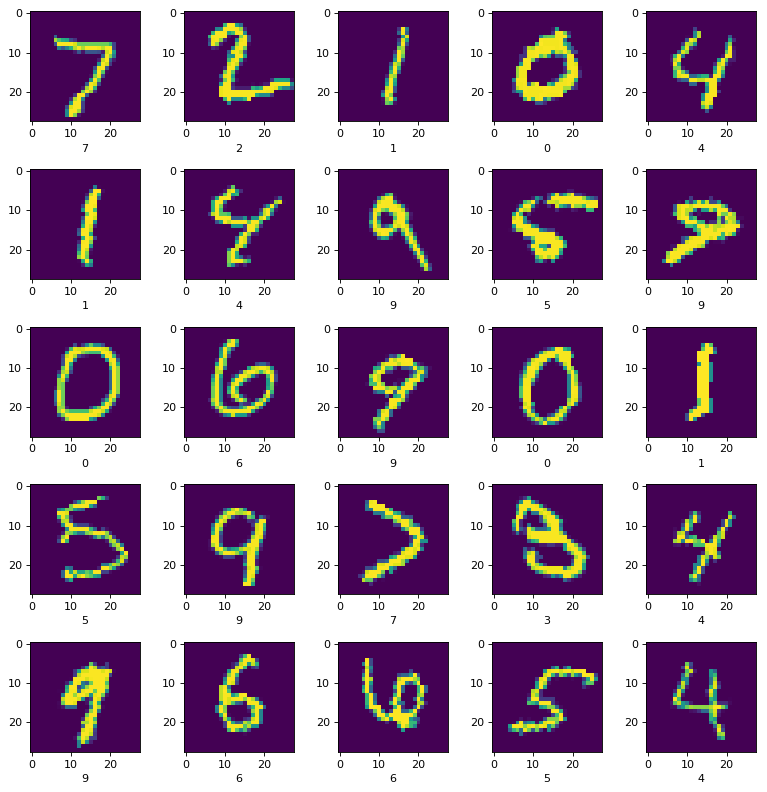

In [6]:
x = next(iter(test_loader))

plotData = x[0][0:25]
labelData = x[1][0:25]

fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
for i in range(25):
    plt.subplot(5,5,i + 1, xmargin = 2.0)
    plt.xlabel(str(labelData[i].numpy()))
    plt.imshow(plotData[i][0].numpy())
    plt.tight_layout()
plt.show()

## Building a Vanilla CNN
Fill in the code below to build a model following these instructions.

1. INPUT -> 
2. CONV(outputChannels = 16, kernelSize = 5, stride=1, padding = 0) -> ReLU -> MAXPOOL(kernelSize=2) ->
3. CONV(outputChannels = 32, kernelSize = 5, stride=1, padding = 0) -> ReLU MAXPOOL(kernelSize=2) ->
4. FCNN(32 * 4 * 4, 10)

In the forward pass you'll have to reshape your outputs to fit into a 2 dimensional FCNN. Check out the view() function from PyTorch.
The code below was snagged from www.deeplearningwizard.com, but you should be able to figure out how to code this up without peaking.

In [7]:
class CNNModelStatic(nn.Module):
    def __init__(self):
        super(CNNModelStatic, self).__init__()

        # Convolution 1
        #### your code here ###
        self.cnn1 = torch.nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, stride = 1,
                                    padding = 0)#,dilation=1, groups=1, bias=True)
        
        # ReLU 1
        #### your code here ###
        self.relu1 = torch.nn.ReLU()

        # Max pool 1
        #### your code here ###
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size = 2)#, stride=None, padding=0, dilation=1,
                                           #return_indices=False, ceil_mode=False)

        # Convolution 2
        #### your code here ###
        self.cnn2 = torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 1,
                                    padding = 0)#,dilation=1, groups=1, bias=True)
        
        # RelU 2
        #### your code here ###
        self.relu2 = torch.nn.ReLU()

        # Max pool 2
        #### your code here ###
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size = 2)

        # Fully connected 1 (readout)
        #### your code here ###
        self.fc1 = nn.Linear(in_features = 512, out_features = 10)

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max pool 2 
        out = self.maxpool2(out)

        # Resize
        # Reshape your output layer to fit into the final layer of the FCNN
        # Original size: (batch_size, 32, 4, 4)
        # out.size(0): batch_size
        # New out size: (batch_size, 32*4*4)
        #### your code here ###
        out = out.view(out.size(0), 512)
        
        #### end code here ###
        # Linear function (readout)
        out = self.fc1(out)

        return out

### Static Model Summary
Using the summary function from torchsummary print out the layers, shapes, and number of parameters in the model.

In [8]:
#### your code here ###
cnn = CNNModelStatic()
summary(cnn, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
              ReLU-2           [-1, 16, 24, 24]               0
         MaxPool2d-3           [-1, 16, 12, 12]               0
            Conv2d-4             [-1, 32, 8, 8]          12,832
              ReLU-5             [-1, 32, 8, 8]               0
         MaxPool2d-6             [-1, 32, 4, 4]               0
            Linear-7                   [-1, 10]           5,130
Total params: 18,378
Trainable params: 18,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.07
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


## Building a Dynamic CNN
The above code is great for getting an idea of how to build a model. But in production we would want to be able to iterate through multiple different architectural choices like number of layers, filter sizes, pooling kernels, strides, activation functions, etc. In order to be able to do this we need to build our model using arguments which specify the architecture and loops. Otherwise we'd have to explicitly type out every layer of our model, for every change we wanted to implement.

Now just in case any of your are getting flashbacks to lab 4, not to worry. I've implemented most of the function for you. You're encouraged to walk through it to understand what's happening. **All you have to do is implement the method `calculateFinalOutputSize` that calculates the size of the final output, which is needed to calculate the size of the final FCNN layer.**

In [54]:
class CNNModelDynamic(nn.Module):
    def __init__(self, input_shape, n_classes,
                 in_channels_list, out_channels_list,
                 kernel_size_list, stride_list,
                 padding_list, pool_kernel_list,
                 pool_stride_list,
                 pooling_list, activations_list):
        super(CNNModelDynamic, self).__init__()
        localArgs = locals().items()
        argLens = set()
        ignoredArgs = ['self', "__class__", "input_shape", "n_classes"]
        for argName, arg in localArgs:
            if argName not in ignoredArgs:
                argLens.add(len(arg))
        assert len(argLens) == 1, ("mismatch in lengths of arguments."
                                   "All params for each layer must be specified")
        finalOutputSize = self.calculateFinalOutputSize(input_shape,kernel_size_list, stride_list,
                                         padding_list, pool_kernel_list, pool_stride_list)
        modules = list()
        for layerIdx in range(0, argLens.pop()):
            modules.append(nn.Conv2d(in_channels = in_channels_list[layerIdx],
                                 out_channels = out_channels_list[layerIdx],
                                 kernel_size = kernel_size_list[layerIdx],
                                 stride = stride_list[layerIdx],
                                 padding = padding_list[layerIdx]))
            modules.append(activations_list[layerIdx])
            modules.append(pooling_list[layerIdx](kernel_size = pool_kernel_list[layerIdx],
                                                  stride = pool_stride_list[layerIdx]))
        self.convolutions = nn.Sequential(*modules)
        self.finalLayer = nn.Linear(finalOutputSize**2*out_channels_list[-1], n_classes)
        
    def outputFromConvLayer(self, w, k, p, s):
        return (w-k+2*p)/float(s) + 1
    
    def outputFromPoolLayer(self, w, k, s):
        return (w-k)/float(s) + 1
    
    def calculateFinalOutputSize(self, input_shape, kernel_size_list, stride_list,
                                 padding_list, pool_kernel_list, pool_stride_list):
        """
        Calculates the shape of the final output assuming that every conv layer is followed
        by a pooling layer.
        """
         #### your code here ###
        currentInput = input_shape
        for i in range(len(kernel_size_list)):
            currentInput = self.outputFromConvLayer(currentInput, kernel_size_list[i], padding_list[i], stride_list[i])
            currentInput = self.outputFromPoolLayer(currentInput, pool_kernel_list[i], pool_stride_list[i])
        finalOutputShape = currentInput
        
        print("Final shape is", int(finalOutputShape))
        
         #### end code here ###
        return(int(finalOutputShape))
        
        
    def forward(self, x):
        out = self.convolutions(x)
        out = out.view(out.size(0), -1)
        out = self.finalLayer(out)
        return(out)

### Dynamic Model Summary
Using the summary function from torchsummary print out the layers, shapes, and number of parameters in the model.

In [55]:
#### your code here ###
cnnDynamicOG = CNNModelDynamic(input_shape = 28, n_classes = 10,
                 in_channels_list = [1, 16], out_channels_list = [16, 32],
                 kernel_size_list = [5, 5], stride_list = [1, 1],
                 padding_list = [0,0], pool_kernel_list = [2, 2],
                 pool_stride_list = [2, 2],
                 pooling_list = [nn.MaxPool2d, nn.MaxPool2d], activations_list = [nn.ReLU(), nn.ReLU()])
summary(cnnDynamicOG, input_size=(1, 28, 28))

Final shape is 4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
              ReLU-2           [-1, 16, 24, 24]               0
         MaxPool2d-3           [-1, 16, 12, 12]               0
            Conv2d-4             [-1, 32, 8, 8]          12,832
              ReLU-5             [-1, 32, 8, 8]               0
         MaxPool2d-6             [-1, 32, 4, 4]               0
            Linear-7                   [-1, 10]           5,130
Total params: 18,378
Trainable params: 18,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.07
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


## Training a Dynamic CNN
Now we can train our model. First train the original model implemented above. It shoud train just fine and achieve decent accuracy. 

1. Your first task is to implement early stopping by keeping track of your best accuracy and stopping training if accuracy doesn't improve after 3 checks. I suggest that you check your evaluation accuracy every 50 iterations unless you have a GPU then by all means check whenever you want. Hell, check twice an iteration. Ain't nothing stopping you with a GPU. Once your best model is found, quit out and stop running. This is where you'd usually save a model, but don't worry about doing that.

2. Your second task is to experiment with different configurations. Try at least two architectural changes (depth, convolution layers, channels, strides, **optimization**, average pooling, etc) and record some observations about model performance for your two configurations. I would suggest using Adam as an optimization function.

In [56]:
def doTheThing(model, optimizer):
    numIterations = 0
    bestAccuracy = 0
    patience = 2 # how many times should we be ok with our accuracy not increasing?
    checksWithoutIncrease = 0
    num_epochs = 5 # Change later
    for epoch in range(num_epochs):
        print("Epoch: {}".format(epoch))
        for i, (images, labels) in enumerate(train_loader):
            # Load images
            images = images.requires_grad_()

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model.forward(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            numIterations += 1
            if numIterations % 50 == 0:
                correct = 0
                total = 0
                # Iterate through test dataset
                for images, labels in test_loader:
                    # Load images
                    images = images.requires_grad_()

                    # Forward pass only to get logits/output
                    outputs = model.forward(images)

                    # Get predictions from the maximum value
                    _, predicted = torch.max(outputs.data, 1)

                    # Total number of labels
                    total += labels.size(0)

                    # Total correct predictions
                    correct += (predicted == labels).sum()

                accuracy = 100 * correct / total
                # Check if early stopping criteria are met
                #### your code here ###

                if accuracy > bestAccuracy:
                    bestAccuracy = accuracy
                    checksWithoutIncrease = 0
                else:
                    checksWithoutIncrease += 1
                    print("\tGone {} rounds without increasing:".format(checksWithoutIncrease))

                #### end code here ###
                print('\tIteration: {}. Loss: {}. Testing Accuracy: {}'.format(numIterations, loss.item(), accuracy))
        # remember, early stopping is qutting out of all training.
        #### your code here ###
                if checksWithoutIncrease > patience:
                    print("We did not increase accuracy over the past 3 rounds. Quitting!")
                    return bestAccuracy, numIterations * (epoch + 1)
        #### end code here ###

In [57]:
cnnDynamicOG = CNNModelDynamic(input_shape = 28, n_classes = 10,
                 in_channels_list = [1, 16], out_channels_list = [16, 32],
                 kernel_size_list = [5, 5], stride_list = [1, 1],
                 padding_list = [0,0], pool_kernel_list = [2, 2],
                 pool_stride_list = [2, 2],
                 pooling_list = [nn.MaxPool2d, nn.MaxPool2d], activations_list = [nn.ReLU(), nn.ReLU()])
optimizerSGD = torch.optim.SGD(cnnDynamicOG.parameters(), lr=learning_rate)
optimizerAdam = torch.optim.Adam(cnnDynamicOG.parameters())

Final shape is 4


In [73]:
cnnDynamiclargerKernels = CNNModelDynamic(input_shape = 28, n_classes = 10,
                 in_channels_list = [1, 16], out_channels_list = [16, 32],
                 kernel_size_list = [8, 8], stride_list = [1, 1],
                 padding_list = [0,0], pool_kernel_list = [2, 2],
                 pool_stride_list = [2, 2],
                 pooling_list = [nn.MaxPool2d, nn.MaxPool2d], activations_list = [nn.ReLU(), nn.ReLU()])
optimizerSGDlargerKernels = torch.optim.SGD(cnnDynamiclargerKernels.parameters(), lr=learning_rate)

Final shape is 1


In [ ]:
cnnDynamiclargerKernels = CNNModelDynamic(input_shape = 28, n_classes = 10,
                 in_channels_list = [1, 16], out_channels_list = [16, 32],
                 kernel_size_list = [8, 8], stride_list = [1, 1],
                 padding_list = [0,0], pool_kernel_list = [2, 2],
                 pool_stride_list = [2, 2],
                 pooling_list = [nn.MaxPool2d, nn.MaxPool2d], activations_list = [nn.ReLU(), nn.ReLU()])
optimizerSGDlargerKernels = torch.optim.SGD(cnnDynamiclargerKernels.parameters(), lr=learning_rate)

In [65]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01

In [74]:
# bestAccuracyOriginal, totalIterationsOriginal = doTheThing(cnnDynamicOG, optimizerSGD)
# bestAccuracyWithAdam, totalIterationsWithAdam = doTheThing(cnnDynamicOG, optimizerAdam)
bestAccuracyWithLargerKernels, totalIterationsWithLargerKernels = doTheThing(cnnDynamiclargerKernels, optimizerSGDlargerKernels)


Epoch: 0
	Iteration: 50. Loss: 2.261282444000244. Testing Accuracy: 13
	Iteration: 100. Loss: 2.19022274017334. Testing Accuracy: 31
	Iteration: 150. Loss: 2.08729887008667. Testing Accuracy: 49
	Iteration: 200. Loss: 1.8707693815231323. Testing Accuracy: 56
	Iteration: 250. Loss: 1.678735375404358. Testing Accuracy: 64
	Iteration: 300. Loss: 1.2326034307479858. Testing Accuracy: 72
	Iteration: 350. Loss: 0.9652111530303955. Testing Accuracy: 74
	Iteration: 400. Loss: 0.6076298356056213. Testing Accuracy: 77
	Iteration: 450. Loss: 0.7554090619087219. Testing Accuracy: 79
	Iteration: 500. Loss: 0.6046813726425171. Testing Accuracy: 80
	Iteration: 550. Loss: 0.5280731320381165. Testing Accuracy: 81
	Gone 1 rounds without increasing:
	Iteration: 600. Loss: 0.48492884635925293. Testing Accuracy: 81
Epoch: 1
	Iteration: 650. Loss: 0.43832606077194214. Testing Accuracy: 82
	Gone 1 rounds without increasing:
	Iteration: 700. Loss: 0.34086087346076965. Testing Accuracy: 82
	Iteration: 750. Los

In [76]:
print("With the original settings, the best accuracy achieved was {}, after {} iterations.".format(bestAccuracyOriginal, totalIterationsOriginal))
print("Using Adam as the optimizer, the best accuracy achieved was {}, after {} iterations.".format(bestAccuracyWithAdam, totalIterationsWithAdam))
print("With a larger kernel size, the best accuracy achieved was {}, after {} iterations.".format(bestAccuracyWithLargerKernels, totalIterationsWithLargerKernels))



With the original settings, the best accuracy achieved was 85, after 1900 iterations.
Using Adam as the optimizer, the best accuracy achieved was 93, after 550 iterations.
With a larger kernel size, the best accuracy achieved was 86, after 3900 iterations.
